<a href="https://colab.research.google.com/github/Masyithah28/PembelajaranMesin_Ganjil_2024/blob/main/Kelompok_2_UTS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# UTS - Machine Leraning
## Kelompok 2 - SREGEP:
*   Agung Rizky Setiawan  / 01 / 2241720187
*   Ersa Oktavian Ramadan / 09   / 2241720208
*   Masyithah Sophia Damayanti / 15 / 2241720011  
*   Rifki Fakhrudin / 23 / 2241720218




## Persiapan Data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:

import kagglehub

# Download latest version
path = kagglehub.dataset_download("ntl0601/casia-webface")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/ntl0601/casia-webface/versions/1


## Import Library

In [4]:
from pathlib import Path
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import cv2
import random
import numpy as np
import pandas as pd
import os
import glob
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.utils import to_categorical
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

## Load Data

In [5]:
# Path dataset (ubah sesuai lokasi dataset Anda)
dataset_path = "/root/.cache/kagglehub/datasets/ntl0601/casia-webface/versions/1/casia-webface"

Found 396673 images belonging to 10572 classes.


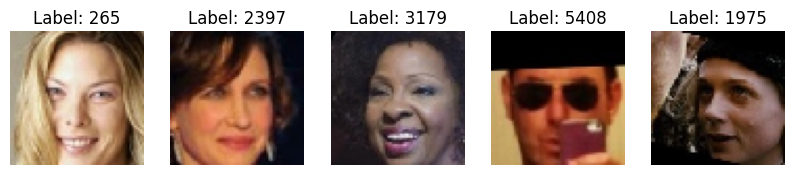

In [6]:
# Membuat ImageDataGenerator untuk mengelola dataset gambar
data_gen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

# Membuat generator data untuk training dan validasi
train_data = data_gen.flow_from_directory(
    dataset_path,
    target_size=(64, 64),
    batch_size=16,
    class_mode='categorical',
    subset='training',
    shuffle=True  # Pastikan data tetap acak
)
data_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

def show_sample_images(data_generator, num_images=5):

    # Mengambil batch data pertama
    images, labels = next(data_generator)

    # Menampilkan gambar
    plt.figure(figsize=(10, 10))
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(images[i])
        plt.title(f"Label: {np.argmax(labels[i])}")  # Menampilkan label numerik
        plt.axis('off')
    plt.show()


# Tampilkan 5 gambar contoh dari data training
show_sample_images(train_data)

## Preprocessing

In [11]:
# Mendapatkan semua path gambar
image_paths = [os.path.join(root, file)
               for root, _, files in os.walk(dataset_path)
               for file in files]

# Mengambil 100 gambar acak
random.seed(42)
sampled_paths = random.sample(image_paths, min(100, len(image_paths)))

# Membuat list gambar dan label
train_img = [(cv2.imread(path), os.path.basename(os.path.dirname(path))) for path in sampled_paths]

# Fungsi untuk mengubah ukuran gambar
def standarized_input(image):
    # 2. Penyesuaian ukuran gambar
    return cv2.resize(image, (1100, 600))

# Fungsi untuk mengencode label
def label_encoder(label):
    # 1. Standardisasi nilai fitur ataupun label
    return 1 if label == 'day' else 0

# Fungsi preprocessing
def preprocess(img_list):
    std_img_list = []

    for image, label in img_list:
        # 3. Perubahan colorspace gambar
        std_img = standarized_input(image)
        std_img = cv2.cvtColor(std_img, cv2.COLOR_BGR2GRAY)

        # Standardisasi nilai label
        img_label = label_encoder(label)

        std_img_list.append((std_img, img_label))

    return std_img_list

# Proses preprocessing pada gambar yang diambil secara acak
train_std_img_list = preprocess(train_img)

# Contoh pemeriksaan ukuran gambar yang sudah diproses
pick_random = np.random.randint(0, len(train_std_img_list))
print(f'Image {pick_random}')
print(train_std_img_list[pick_random][0].shape)

Image 98
(600, 1100)


## Build Model

In [12]:
# Normalisasi data gambar
X = np.array([img for img, _ in train_std_img_list]) / 255.0  # Normalisasi Data Gambar
y = np.array([label for _, label in train_std_img_list])  # Data Label

# Mengubah bentuk data menjadi 4D jika diperlukan (jumlah gambar, tinggi, lebar, channel)
X = X.reshape(X.shape[0], X.shape[1], X.shape[2], 1)

# Mengonversi label ke format one-hot encoding
y = to_categorical(y)

# Membuat augmentasi data menggunakan ImageDataGenerator
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range=0.05,
    zoom_range=0.05,
    horizontal_flip=True,
    fill_mode="nearest"
)

# Membangun model neural network
model = Sequential()

# 1. Pembuatan input layer dan hidden layers
model.add(Input(shape=(600, 1100, 1)))  # Menggunakan Input sebagai layer pertama
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.3))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.001)))  # Mengurangi l2
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.001)))  # Mengurangi l2
model.add(Dropout(0.5))

# 2. Pembuatan output layer
model.add(Dense(1, activation='sigmoid'))

# 3. Compile Model
model.compile(optimizer=Adam(learning_rate=0.0005),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# 4. Menambahkan Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# 5. Proses fitting model
history = model.fit(X, y, epochs=30, batch_size=16, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 136s 26s/step - accuracy: 0.9845 - loss: 0.4905 - val_accuracy: 1.0000 - val_loss: 0.3309
Epoch 2/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 140s 26s/step - accuracy: 0.9778 - loss: 1.7207 - val_accuracy: 1.0000 - val_loss: 0.5218
Epoch 3/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 146s 26s/step - accuracy: 0.9741 - loss: 1.7965 - val_accuracy: 1.0000 - val_loss: 0.6513
Epoch 4/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 148s 28s/step - accuracy: 1.0000 - loss: 0.6744 - val_accuracy: 1.0000 - val_loss: 0.7388
Epoch 5/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 138s 27s/step - accuracy: 0.9958 - loss: 0.8641 - val_accuracy: 1.0000 - val_loss: 0.7809
Epoch 6/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 143s 27s/step - accuracy: 0.9856 - loss: 0.8935 - val_accuracy: 1.0000 - val_loss: 0.7983


## Evaluation

In [13]:
# 1. Pisahkan data menjadi data training dan data testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 2. Evaluasi model menggunakan data testing
test_loss, test_accuracy = model.evaluate(X_test, y_test)

# 3. Tampilkan hasil evaluasi
print(f'Test Loss: {test_loss:.2f}%')
print(f'Test Accuracy: {test_accuracy:.2f}%')


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - accuracy: 1.0000 - loss: 0.3309
Test Loss: 0.33%
Test Accuracy: 1.00%


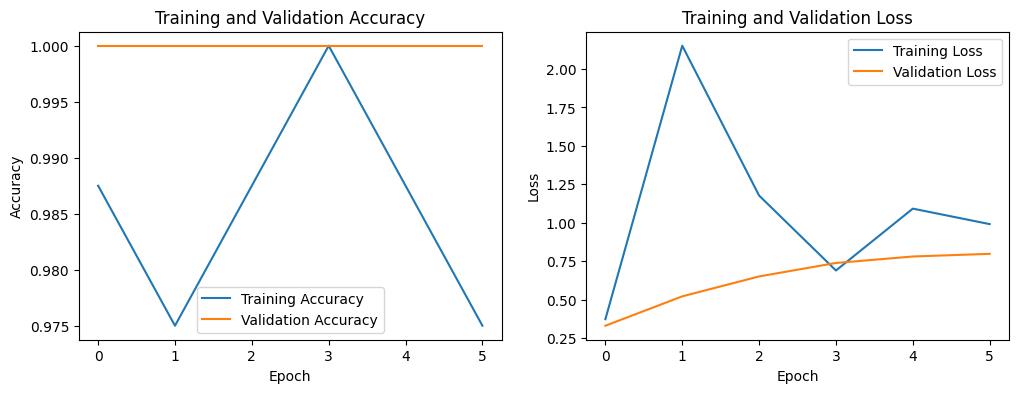

In [14]:
# Plotting Akurasi dan Loss
plt.figure(figsize=(12, 4))

# Plotting Akurasi
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

# Plotting Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.show()
